# This script is generating a complete location file and a complete trait file

In [10]:
#Function Read weather
#Weather()
#Input: lat, lon, year, sowing, heading, flower, maturity, harvest
import pandas as pd
import numpy as np
import datetime as dt
import os

In [4]:
#Nursery
nursery=['ESWYT','IDYN','HTWYT','SAWYT','IWWYT_IRR','IWWYT_SA']
nur_start=[1,12,1,1,3,7]
nur_end=[40,51,18,27,20,19]
xls=['.xls','.xls','.csv','.xls','.xlsx','.xlsx']
delim=['\t','\t',',','\t']
#HTWYT only has one location file

In [5]:
#file_name="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Weather\\MelArc\\" #Metblue
file_name="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Weather\\ARC5\\" #ARC5
output_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\1.0_Cross_Over\\1_Data\\"
#file_name=file_name+str(lat)+"_"+str(lon)+".csv"
#df=pd.read_csv(file_name)
def switch_mon(argument):
    switcher = {
        "Jan":1,
        "Feb":2,
        "Mar":3,
        "Apr":4,
        "May":5,
        "Jun":6,
        "Jul":7,
        "Aug":8,
        "Sep":9,
        "Oct":10,
        "Nov":11,
        "Dec":12
    }
    return switcher.get(argument)

# Dealing with Locations

In [44]:
#dt.datetime.strptime("1981-1-1",'%Y-%m-%d')
env

'E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Data\\IWWYT_IRR\\9IWWYT_IRR_EnvData.xlsx'

In [42]:
#[dt.datetime.strptime(x,'%Y-%m-%d') if str(x)!='nan' else float('nan') for x in df1.sow]


In [45]:
#Create a location file including sowing, harvesting, heading, anthesis, and maturity
#Read location and environment file
for n in range(6):
    nurse=nursery[n]
    df=pd.DataFrame(columns=['loc','country','lat','lon','alt','trail','year','yearofsow','dayofsow','dayofhar','head_mean','anth_mean','matu_mean'])
    default_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Data\\"+nurse+"\\"
    for yr in range(nur_start[n],(nur_end[n]+1)):
        loc=default_dir+str(yr)+nurse+"_Loc_data"+xls[n]
        if (n==2 and yr<17):loc=default_dir+str(1)+nurse+"_Loc_data"+xls[n] #HTWYT only has one loc file
        env=default_dir+str(yr)+nurse+"_EnvData"+xls[n]
        #Location file
        if os.path.isfile(loc):
            if n<4:
                df1=pd.read_table(loc,delim[n],encoding = "ISO-8859-1") #Location file
            else:
                df1=pd.read_excel(loc)
            #Compute latitude and longitude
            df1['lat']=[-1 if x == 'S' else 1 for x in df1['Latitud']]*round(df1['Lat_degress']+df1['Lat_minutes']/60,2)
            df1['lon']=[-1 if x == 'W' else 1 for x in df1['Longitude']]*round(df1['Long_degress']+df1['Long_minutes']/60,2)
            #Subset Location file
            df1=df1[['Loc_no','Country','lat','lon','Altitude']]
            df1.columns=['loc','country','lat','lon','alt']
            df1=df1.drop_duplicates(keep='first') #remove duplicated rows
            #Here we need to judge if there are lines in environment file, otherwise, create empty sowing and harvest columns
            #Identify year through environment file
            #Need to check if environment file exit.
            if os.path.isfile(env):
                if n<4:
                    df2=pd.read_table(env,delim[n],encoding = "ISO-8859-1") #Environment file
                else:
                    df2=pd.read_excel(env)
                #Estimate Sow date in environment file: Trait No==3, Trait Name == SOWING_DATE
                #df2['year']=[1900+100*int((100-int(str(x)[:2]))/80)+int(str(x)[:2]) for x in df2['Cycle']]
                df2_temp=df2[df2['Trait No']==3][['Loc_no','Country','Value']] #Trait No 3 is sowing
                if df2_temp.shape[0]>0:
                    df2_temp=df2_temp.dropna()
                    df2_temp['sow']=[x.split()[2]+'-'+str(switch_mon(x.split()[0]))+'-'+x.split()[1] for x in df2_temp['Value']]
                    df2_temp=df2_temp[['Loc_no','sow']]
                    df2_temp.columns=['loc','sow']
                    df1=df1.merge(df2_temp,left_on='loc',right_on='loc',how='left')
                else:
                    df1['sow']='nan'
                #else:
                #    df1['sow']='nan'
                #Estimate Harvest date in environment file: Trait No==9, Trait Name==HARVEST_FINISHING_DATE
                df2_temp=df2[(df2['Trait No']==8)|(df2['Trait No']==9)][['Loc_no','Trait name','Value']]
                df2_temp=df2_temp.pivot_table(index=['Loc_no'],columns=['Trait name'],values=['Value'],aggfunc='first',fill_value='nan').reset_index()
                if df2_temp.shape[0]>0:
                    df2_temp.columns=['loc']+['har_'+str(x+1) for x in range(df2_temp.shape[1]-1)]
                    if df2_temp.shape[1]==2:
                        df2_temp['har']=df2_temp['har_1']
                        df2_temp.drop(['har_1'],axis=1,inplace=True,errors='ignore')
                    if df2_temp.shape[1]==3:
                        df2_temp['har']=[df2_temp.loc[x,'har_1'] if df2_temp.loc[x,'har_1']!='nan' else df2_temp.loc[x,'har_2'] for x in range(df2_temp.shape[0])]
                        df2_temp.drop(['har_1','har_2'],axis=1,inplace=True,errors='ignore')
                    df2_temp['har']=[x.split()[2]+'-'+str(switch_mon(x.split()[0]))+'-'+x.split()[1] if x!='nan' else 'nan' for x in df2_temp['har']]
                    df1=df1.merge(df2_temp,left_on=['loc'],right_on=['loc'],how='left')
                else:
                    df1['har']='nan'
            #else:
            #    df1[['sow','har']]='nan'
            #Find heading, flowering and maturity date from MeanVal
            #Heading date: 148, Flower: 149, Maturity: 150
            meanval=default_dir+str(yr)+nurse+"_MeanVal"+xls[n]
            if os.path.isfile(meanval):
                if n<4:
                    df2=pd.read_table(meanval,delim[n],encoding = "ISO-8859-1") #MeanVal file
                else:
                    df2=pd.read_excel(meanval)
                year=str(df2.loc[0,'Cycle'])
                year=1900+100*int((100-int(year[:2]))/80)+int(year[:2]) if year.find('-')>0 else int(float(year))
                #trail_name=df2.loc[0,'Trial name']
                #df2['year']=['19'+x[:2] if len(x)>4 else x[:4] for x in df2['Cycle']]
                df2=df2[(df2['Trait_no']>=148)&(df2['Trait_no']<=150)][['Occ','Loc_no','Trait_no','Trait name','Value']]
                df2['Value']=pd.to_numeric(df2['Value'],errors='coerce')
                #Compuate the mean day of heading, flowering and maturity for each site
                #merge heading, anthesis, maturity day into location file
                trait_no=[148,149,150]
                trait_name=['head_mean','anth_mean','matu_mean']
                for i in range(len(trait_no)):
                    df2_temp=df2[df2['Trait_no']==trait_no[i]][['Loc_no','Value']]
                    if df2_temp.shape[0]>0:
                        df2_temp=df2_temp.groupby(['Loc_no']).mean().round(0).reset_index()
                        df2_temp.columns=['loc',trait_name[i]]
                        df1=df1.merge(df2_temp,how='left')
                    #else:
                    #    df1[trait_name[i]]='nan'
            df1['year']=year
            df1['trail']=str(yr)+nurse
            df1['yearofsow']=[x.split('-')[0] if str(x)!='nan' else float('nan') for x in df1['sow']]
            df1['dayofsow']=[(dt.datetime(int(x.split('-')[0]),int(x.split('-')[1]),int(x.split('-')[2]))-dt.datetime(int(x.split('-')[0]),1,1)).days if str(x)!='nan' else float('nan') for x in df1.sow]
            df1['dayofhar']=(df1['har'].astype('datetime64[ns]')-df1['sow'].astype('datetime64[ns]')).dt.days
            df1.drop(columns=['sow','har'],inplace=True)
            df=df.append(df1,ignore_index=True,sort=False)
    df.drop_duplicates(keep='first',inplace=True)
    df.to_csv(output_dir+nurse+'_loc.csv',index=False)

# Dealing with Yield and other traits

In [234]:
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import optimize

In [235]:
#Generating yield table
for n in range(6):
    nurse=nursery[n]
    df=pd.DataFrame(columns=['occ','loc','year','sid','gen','yld'])
    for yr in range(nur_start[n],(nur_end[n]+1)):
        default_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Data\\"+nurse+"\\"
        yld=default_dir+str(yr)+nurse+"_GrnYld"+xls[n]
        if os.path.isfile(yld):
            if n<4:
                df1=pd.read_table(yld,delim[n],encoding = "ISO-8859-1") #Location file
            else:
                df1=pd.read_excel(yld)
            df1['year']=[1900+100*int((100-int(str(x)[:2]))/80)+int(str(x)[:2]) if len(str(x))>4 else int(x) for x in df1['Cycle']]
            df1=df1[['Occ','Loc_no','year','Sid','Gen_name','Value']]
            df1.columns=['occ','loc','year','sid','gen','yld']
            df=df.append(df1,ignore_index=True,sort=False)
    df.to_csv(output_dir+nurse+'_yld.csv',index=False)

In [46]:
#Generating a table including yield, phenology and location information
df1=[]
df2=[]
trait_no=[148,149,150]
trait_name=['head','anth','matu']
for n in range(4,6):
    nurse=nursery[n]
    df=pd.DataFrame(columns=['occ','loc','year','country','lat','lon','alt','trail','sid','gen','yld','yearofsow','dayofsow','head','anth','matu','dayofhar','head_mean','anth_mean','matu_mean'])
    default_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Data\\"+nurse+"\\"
    for yr in range(nur_start[n],(nur_end[n]+1)):
        yld=default_dir+str(yr)+nurse+"_GrnYld"+xls[n]
        mea=default_dir+str(yr)+nurse+"_MeanVal"+xls[n]
        if os.path.isfile(yld):
            if n<4:
                df1=pd.read_table(yld,delim[n],encoding = "ISO-8859-1") #Location file
                df2=pd.read_table(mea,delim[n],encoding = "ISO-8859-1") #Other traits
            else:
                df1=pd.read_excel(yld)
                df2=pd.read_excel(mea)
            df1['year']=[1900+100*int((100-int(str(x)[:2]))/80)+int(str(x)[:2]) if len(str(x))>4 else int(x) for x in df1['Cycle']]
            df1=df1[['Occ','Loc_no','year','Sid','Gen_name','Value']]
            df1.columns=['occ','loc','year','sid','gen','yld']
            df2['year']=[1900+100*int((100-int(str(x)[:2]))/80)+int(str(x)[:2]) if len(str(x))>4 else int(x) for x in df2['Cycle']]
            #Heading,anthesis,maturity
            for t in range(len(trait_no)):
                df3=df2[df2['Trait_no']==trait_no[t]][['Occ','Loc_no','year','Sid','Gen_name','Value']] 
                df3.columns=['occ','loc','year','sid','gen',trait_name[t]]
                df3['occ']=df3['occ'].astype('float')
                df1=df1.merge(df3,how='left',on=['occ','loc','year','sid','gen'])
            #Location file contain sowing and harvesting date
            df2=pd.read_csv(output_dir+nurse+'_loc.csv')
            #dayofyear,dayofsow,dayofhar
            df3=df2[['loc', 'year','country','lat','lon','alt','trail','yearofsow', 'dayofsow', 'dayofhar','head_mean','anth_mean','matu_mean']]
            df1=df1.merge(df3,how='left',on=['loc','year'])
            df=df.append(df1,ignore_index=True,sort=False)
        df.to_csv(output_dir+nurse+'_yld_phe_loc.csv',index=False)

# ##################Modeling missing heading date#####################
###################################################################

In [47]:
import os
import glob
from datetime import timedelta
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [49]:
#Windows
base_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\1.0_Cross_Over\\"
in_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\1.0_Cross_Over\\2_Results\\NP_data\\"
data_out=in_dir+"phenologymodeling\\"#"E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\1.0_Cross_Over\\2_Results\\NP_data\\"
plot_out="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\1.0_Cross_Over\\6_Figures\\NP_Plots\\"
weat_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Weather\\MelArc\\"
#weat_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Weather\\ARC5\\"
#Mac:
#in_dir="/Users/weixiong/Dropbox (RSG)/Works/CurrentProcessing/Wheat_Phenotypic/1_Cross_Over/1_Data/"
#out_dir="/Users/weixiong/Dropbox (RSG)/Works/CurrentProcessing/Wheat_Phenotypic/1_Cross_Over/6_Figures/NCC_Dataprocessing/"
#weat_dir="/Users/weixiong/Dropbox (RSG)/Works/CurrentProcessing/Wheat_Phenotypic/Weather/Output/"
#os.chdir(out_dir)
nursery=['ESWYT','IDYN','HTWYT','SAWYT','IWWYT_IRR','IWWYT_SA']
wea=['MelArc','ARC5']

In [ ]:
# Step 0: Clear the data, generating table for the CROP MODEL phenology perdiction

In [50]:
out=pd.DataFrame(columns=['nursery','year','E!','lat','lon','yearofsow','dayofsow','head','anth','matu','dayofhar'])
for n in nursery[4:]: #'HTWYT'
    df=pd.read_csv(output_dir+n+'_yld_phe_loc.csv',low_memory=False)
    df.loc[:,'E!']=df['occ'].astype('str')+'_'+df['loc'].astype('str')
    df.loc[:,'G!']=df['sid'].astype('str')+'_'+df['gen']
    df=df[['E!','G!','year','lat','lon','yld','yearofsow','dayofsow','head','anth','matu','dayofhar']]
    df=df[df.lat.notnull()&df.lon.notnull()]
    df=df[df['yearofsow']>1979].reset_index().drop(['index'],axis=1) #New weather from 1980
    df.drop_duplicates(keep='first',inplace=True)
    for col in df.columns[2:]: 
        df[col]=df[col].replace(r'\s+',np.nan,regex=True)
        df[col]=df[col].astype('float')
    E_mean=df.groupby(['E!','year']).median().reset_index()
    E_sd=df.groupby(['E!','year']).std().reset_index()
    E_mean['head_sd']=E_sd['head']
    E_mean['head_mean']=E_mean['head']
    remove=E_mean[(E_mean['head']>E_mean['matu']) | (E_mean['head']>E_mean['dayofhar'])].index.tolist()
    E_mean=E_mean.drop(E_mean.index[remove])
    E_mean=E_mean.pivot_table(index=['year','E!','lat','lon'],values=['yearofsow','dayofsow','head','anth','matu','dayofhar']).reset_index()
    E_mean['nursery']=n
    out=out.append(E_mean,sort=False)
out.to_csv(data_out+"Model_Phenology.csv",index=False)

In [63]:
#Find dssat soil to facilitate its simulation
soil=pd.read_csv("E:/Dropbox (RSG)/Works/CurrentProcessing/Wheat_Phenotypic/2_DegreeDay/1_Data/DSSATgridSoil_10km.txt",
        sep=",")
sol=[]
for i in out.index:
    lat=out.lat[i]
    lon=out.lon[i]
    soil_t=soil[(abs(soil['X']-lon)<1) & (abs(soil['Y']-lat)<1)]
    soil_t['dis']=((soil['X']-lon)**2+(soil['Y']-lat)**2)**(1/2)
    sol=sol+[soil_t.sort_values(by='dis').reset_index().iloc[0,1]]
out['SOL']=sol
out=out.reset_index()
out['ARC5weat']=[cloest_wea(out.lat[i],out.lon[i]) for i in range(out.shape[0])]
out.to_csv(data_out+"Model_Phenology_sol.csv",index=False)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [36]:
#Create calibration and validation files
new=out[['nursery','year']].drop_duplicates().reset_index()
new['caligeno']=range(new.shape[0])
new=new.drop(columns='index')
out=out.merge(new,on=['nursery','year'],how='left')
out.to_csv(data_out+"Model_Phenology_sol.csv",index=False)

In [139]:
#Generate the sol file for all nursery sites
sol_dir="F:/Stuff_in_IIASA/DSSATglobalSoil/SoilGrids-for-DSSAT-10km v1.0 (by country)/"
#output file name
nurserysoil=out_dir+"all_nursery_soil_type1.txt"
#read all soil types
sol=pd.read_csv(out_dir+'Nurserysoil.csv')
sol['country']=[sol.iloc[i,1][:2] for i in range(sol.shape[0])]
soil_output=open(nurserysoil,'a')
for country in sol['country'].unique():
    soil_input=sol_dir+country+".SOL"
    soil_type=sol[sol['country']==country]['SOIL'].tolist()
    with open(soil_input) as f:
        i=15
        for line in f:
            if line[1:11] in soil_type:
                i=1
            i=i+1
            if i<15: soil_output.write(line)
    #soil_input.close()
soil_output.close()
out['weat']=[cloest_wea(out.iloc[i,3],out.iloc[i,4]) for i in range(out.shape[0])]
out.to_csv(data_out+"Model_Phenology_sol.csv",index=False)

In [142]:
#Plot _S  Predict heading  - calibration and validation
out=pd.read_csv("Model_Phenology_sol.csv")[['nursery','year','E!','head','anth','matu']]
df=pd.read_csv("IWIN_CalibratedRows_HeadAnth.csv")[['nursery','year','E!','phen']]
df=df[df['phen']=='head']
df['year']=df['year'].astype('float')
out=out.merge(df,how='left')
df=pd.read_csv("IWIN_SimulationOutput_OnlyHeading_1.csv")[['nursery','year','E!','sim_head','sim_anth','sim_matu']]
df['year']=df['year'].astype('float')
df=df[df['sim_head']>0]
out=out.merge(df,how='left')

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=1,figsize=(6,5.8))
df=out[out['phen']=='head'][['head','sim_head']].dropna()
axs.scatter(df['head'],df['sim_head'],s=10,marker='o',c='b',alpha=0.5,label='Calibration')
df=out[out['phen']!='head'][['head','sim_head']].dropna()
axs.scatter(df['head'],df['sim_head'],s=10,marker='o',c='r',alpha=0.5,label='Validation')
df=out[['head','sim_head']].dropna()
sns.regplot(df['head'],df['sim_head'],ax=axs,ci=0,scatter=False,line_kws={"c":"black","lw":1})
axs.set_xlim([27,220])
axs.set_ylim([27,220])
axs.set_xlabel("Reported heading",fontsize=12)
axs.set_ylabel("Simulated heading",fontsize=12)
axs.legend(loc='lower right',fontsize=12)
corr,_=pearsonr(df['head'],df['sim_head'])
r2=round(corr**2,3)
axs.text(160,190,'R$\mathregular{^{2}}$ = %0.3f' % r2)
#fig.savefig(base_dir+"6_Figures/NCC_Revision1_Suppl/S1_Heading_prediction.png",dpi=300,bbox_inches = 'tight')

# Clear the data, combined predicted mean heading for missing records

In [52]:
#Find the climate for all sites
def cloest_wea(lat,lon):
    wea=[os.path.splitext(os.path.basename(x))[0] for x in glob.glob(weat_dir+"*.csv")]
    wea=pd.DataFrame([x.split('_') for x in wea])
    wea['la']=wea.iloc[:,0].astype('float')
    wea['lo']=wea.iloc[:,1].astype('float')
    wea['dis']=((wea['la']-lat)**2+(wea['lo']-lon)**2)**(1/2)
    min_value=wea['dis'].min()
    #min_index=np.argmin(wea['dis'])
    min_index=wea['dis'].idxmin(axis=0,skipna=True)
    if min_value<50:
        return wea.iloc[min_index,0]+"_"+wea.iloc[min_index,1]
    else:
        return np.nan
    
def tavg(lat,lon,year,sow,har,v):
    file=weat_dir+cloest_wea(lat,lon)+'.csv'
    value=np.nan
    if os.path.isfile(file)&(not np.isnan(sow))&(not np.isnan(har)):
        df_we=pd.read_csv(file)
        start=datetime.datetime.strptime(str(int(year))+'-01-01','%Y-%m-%d')+timedelta(int(sow))
        end=start+timedelta(int(har))
        start=int(start.strftime('%Y%m%d'))
        end=int(end.strftime('%Y%m%d'))
        df_we=df_we[(df_we['Date']>=start)&(df_we['Date']<=end)]
        if (v=='tavg'): value=round((df_we['Tmax_degC'].mean()+df_we['Tmin_degC'].mean())/2,1)
        if (v=='tmax'): value=round(df_we['Tmax_degC'].mean(),1)
        if (v=='tmin'): value=round(df_we['Tmin_degC'].mean(),1)
        if (v=='tdr'): value=abs(round(df_we['Tmax_degC'].mean()-df_we['Tmin_degC'].mean(),1))
        if (v=='prep'): value=round(df_we['Prec_mm_day'].sum(),1)
        if (v=='rhd'): value=round(df_we['RH_percentage'].mean(),1)
        if (v=='vpd'): value=round(df_we['VPD_hPa'].mean(),1)
        if (v=='wp2'): value=round(df_we['WS_ms'].mean(),1)
    return value

def gdd(lat,lon,year,sow,har):
    file=weat_dir+cloest_wea(lat,lon)+'.csv'
    value=np.nan
    if os.path.isfile(file)&(not np.isnan(sow))&(not np.isnan(har)):
        df_we=pd.read_csv(file)
        start=datetime.datetime.strptime(str(int(year))+'-01-01','%Y-%m-%d')+timedelta(int(sow))
        end=start+timedelta(int(har))
        start=int(start.strftime('%Y%m%d'))
        end=int(end.strftime('%Y%m%d'))
        df_we=df_we[(df_we['Date']>=start)&(df_we['Date']<=end)]
        tavg=round((df_we['Tmin_degC']+df_we['Tmax_degC'])/2,1)
        tavg=[0 if x<0 else x if x<35 else 35 for x in tavg]
        value=sum(tavg)
    return value

In [401]:
#Step 1: Clear the data, combined predicted mean heading for missing records
#Combine modelling heading for all missing point.
#Remove questionable entries
#Remove sites where head>matu or head>dayofhar
#sim_df=pd.read_csv("IWIN_SimulationOutput_1.csv")[['nursery','year','E!','sim_head','sim_anth','sim_matu']]
sim_df=pd.read_csv(in_dir+"IWIN_SimulationOutput_HeadAnth.csv")[['nursery','year','E!','sim_head','sim_anth','sim_matu']]
for n in nursery[:4]: #'HTWYT'
    df=pd.read_csv(output_dir+n+'_yld_phe_loc.csv',low_memory=False)
    df.loc[:,'E!']=df['occ'].astype('str')+'_'+df['loc'].astype('str')
    df.loc[:,'G!']=df['sid'].astype('str')+'_'+df['gen']
    df=df[['E!','G!','year','lat','lon','yld','yearofsow','dayofsow','head','anth','matu','dayofhar','head_mean','anth_mean','matu_mean']]
    df=df[df.lat.notnull()&df.lon.notnull()]
    df=df[df['yearofsow']>1979].reset_index().drop(['index'],axis=1) #New weather from 1980
    df.drop_duplicates(keep='first',inplace=True)
    for col in df.columns[2:]: 
        df[col]=df[col].replace(r'\s+',np.nan,regex=True)
        df[col]=df[col].astype('float')
    E_mean=df.groupby(['E!','year']).mean().reset_index()
    #E_sd=df.groupby(['E!','year']).std().reset_index()
    E_mean['head_sd']=E_sd['head']
    E_mean['head_mean']=E_mean['head']
    remove=E_mean[(E_mean['head']>E_mean['matu']) | (E_mean['head']>E_mean['dayofhar'])].index.tolist()
    E_mean=E_mean.drop(E_mean.index[remove])
    E_mean=E_mean[E_mean.lat.notnull() & E_mean.lon.notnull()][['E!','year']]
    df=df.merge(E_mean,how='inner',left_on=['E!','year'],right_on=['E!','year'])
    #Estimate heading, deal with site mean
    #1. A pre-estimated heading day = 56% * harvesting day if there is no reported heading day
    #2. Fit a predition model with doy, 
    #Computing pre-estimated heading tavg
    #Read data with modelling phenology.
    sim=sim_df[sim_df['nursery']==n]
    #Merge the E_mean to df
    #df=df.merge(E_mean,how='inner',on=['E!','year'])
    #Merge the modelling data to df
    df=df.merge(sim[['E!','year','sim_head','sim_anth','sim_matu']],how='left',on=['E!','year'])
    #Save df
    df.to_csv(in_dir+n+'_yld_phe_loc_clean.csv',index=False)

In [496]:
#Step 2: Estimate the climate for sea, veg, rep, gif
#################################Function to generate climate variables#################################################
#Return out is a list with 15 elements
#15 rows: Tmax, Tmin, Tavg, TDR, Pre, Rad, Vpd, Hud, GDD0, GDD8, EDD26, EDD28, EDD30, EDD32, EDD34, EDD36, EDD38, EDD40.
#35 columns: year from 1985 to 2017, plus linear slope and P value 
#veg: sow - 300 GDD before heading
#rep: 200 GDD before heading to 100 GDD after heading
#gfi: 100 GDD after heading to matu
#0:'sea',1:'veg',2:'rep',3:'gfi',4:'bhe',5:'ahe'
def weat_result(file,ye,sow,head,anth,matu):
    pd.set_option('mode.chained_assignment', None)
    out=[None]*32 #18 Climatic indices by 35 year plut slope and sig 
    if os.path.isfile(file):
        df_we=pd.read_csv(file)
        #df_we['Tavg']=round((df_we['Tmin_degC']+df_we['Tmax_degC'])/2,1)
        df_we['Tavg']=round((df_we['Tmin']+df_we['Tmax'])/2,1)
        ye=int(ye)
        sow=int(sow) 
        matu=int(matu)
        sow1=int(str(pd.to_datetime(str(ye)+'-1-1')+timedelta(days=sow))[:10].replace('-',''))  #Sowdate
        matu1=int(str(pd.to_datetime(str(ye)+'-1-1')+timedelta(days=(sow+matu)))[:10].replace('-','')) #Matudate
        
        
        #Identify the heading date
        if str(head)!='nan':
            head1=int(str(pd.to_datetime(str(ye)+'-1-1')+timedelta(days=(sow+int(head))))[:10].replace('-','')) 
        elif str(anth)!='nan':
            anth1=int(str(pd.to_datetime(str(ye)+'-1-1')+timedelta(days=(sow+int(anth))))[:10].replace('-',''))
            gdd=0
            i=0
            while gdd<80:   #80 GDD before the anthesis is the heading
                i=i+1
                we_index=df_we[df_we['Date']==anth1].index
                t=float(df_we.loc[we_index-i,'Tavg']) if df_we.loc[we_index-i,'Tavg'].values>0 else 0
                gdd=gdd+t
            head1=int(df_we.loc[we_index-i,'Date'])
        else:
            head1='nan'
        
        #Identify the 300GDD before and 100 GDD after heading date
        if str(head1)!='nan': #anth-80=head
            gdd=0
            i=0
            while gdd<300:
                i=i+1
                we_index=df_we[df_we['Date']==head1].index
                t=float(df_we.loc[we_index-i,'Tavg']) if df_we.loc[we_index-i,'Tavg'].values>0 else 0
                gdd=gdd+t
            head_b300=int(df_we.loc[we_index-i,'Date'])
            gdd=0
            i=0
            while gdd<100:
                i=i+1
                we_index=df_we[df_we['Date']==head1].index
                t=float(df_we.loc[we_index+i,'Tavg']) if df_we.loc[we_index+i,'Tavg'].values>0 else 0
                gdd=gdd+t
            head_a100=int(df_we.loc[we_index-i,'Date'])
        else:
            head_b300,head_a100=['nan','nan']

        period_s=[sow1,sow1,head_b300,head_a100]
        period_e=[matu1,head_b300,head_a100,matu1]
        out=[]
        for period in range(4):
            if (str(period_s[period])!='nan')&(str(period_e[period])!='nan'):
                df_t=df_we[(df_we['Date']>=period_s[period]) & (df_we['Date']<=period_e[period])]
                #ARC5
                #tmax=round(df_t['Tmax_degC'].mean(),1)
                #tmin=round(df_t['Tmin_degC'].mean(),1)
                #tavg=round(df_t['Tavg'].mean(),1)
                #tdr=round((df_t['Tmax_degC']-df_t['Tmin_degC']).mean(),1)
                #pre=round(df_t['Prec_mm_day'].sum(),1)
                #rad=round(df_t['Rad_Wm2'].mean()*0.0036,1)
                #vpd=round(df_t['VPD_hPa'].mean(),1)
                #hud=round(df_t['RH_percentage'].mean(),1)
                #Meteblue
                tmax=round(df_t['Tmax'].mean(),1)
                tmin=round(df_t['Tmin'].mean(),1)
                tavg=round(df_t['Tavg'].mean(),1)
                tdr=round((df_t['Tmax']-df_t['Tmin']).mean(),1)
                pre=round(df_t['Prec'].sum(),1)
                rad=round(df_t['Rad'].mean()*0.0036,1)
                vpd=round(df_t['VPD'].mean(),1)
                hud=round(df_t['Rh'].mean(),1)
                out=out+[tmax,tmin,tavg,tdr,pre,rad,vpd,hud]
            else:
                out=out+[None]*8
    return out

In [505]:
#NoCHECKed lines, lines except checked lines that have complete records - sow, flower and maturity
nursery=['ESWYT','IDYN','HTWYT','SAWYT']
period=['sea','veg','rep','gfi'] #season, vergation, reproduction, grailfilling, beforeheading, afterheading
for i in range(1,4):  #Nursery
    nurse=nursery[i]
    df1=pd.read_csv(in_dir+nurse+'_yld_phe_loc_clean.csv',low_memory=False)
    #The file it will be appended
    #df0_file=in_dir+nurse+'_ALL_LINES_clean_ARC'+period[p]+'.csv'
    df1['matu1']=[df1.loc[x,['matu','matu_mean','sim_matu','dayofhar']].dropna().tolist()[0] if len(df1.loc[x,['matu','matu_mean','sim_matu','dayofhar']].dropna().tolist())>0 else np.nan for x in df1.index]                           
    df1['head1']=[df1.loc[x,['head','head_mean','sim_head']].dropna().tolist()[0] if len(df1.loc[x,['head','head_mean','sim_head']].dropna().tolist())>0 else np.nan for x in df1.index]
    #ARC5
    #df1=df1[((df1.yearofsow+((df1.dayofsow+df1.matu1)//365))*1000+(df1.dayofsow+df1.matu1)%365<=2019365) & (df1.yearofsow*1000+df1.dayofsow>=1979001)]
    #METE
    df1=df1[((df1.yearofsow+((df1.dayofsow+df1.matu1)//365))*1000+(df1.dayofsow+df1.matu1)%365<=2018365) & (df1.yearofsow*1000+df1.dayofsow>=1985001)]
    if (i==0):
        df1['r_p']='r'
    else:
        df1['r_p']=['p' if (np.isnan(df1['head'][x])&np.isnan(df1.anth[x])) else 'r' for x in df1.index]
    #only deal with records with reported sowing and matu/harv
    df1=df1[df1.dayofsow.notnull()&df1.matu1.notnull()]
    #df1=df1[(df1[pe_e[p]].astype('float')>1)&(df1[pe_e[p]].astype('float')<300)]
    #df1['nursery']=nurse
    columns_name=['tmax','tmin','tavg','tdr','pre','rad','vpd','hud']
    columns_name=[x+'_'+p for p in period for x in columns_name ]
    df2=pd.DataFrame(columns=columns_name)
    for id in df1.index:
        lat,lon,ye,sow,head,anth,matu=df1.loc[id,['lat','lon','yearofsow','dayofsow','head1','anth','matu1']]
        #file,ye,sow,flow_s,flow_e,matu
        file=weat_dir+cloest_wea(lat,lon)+'.csv'
        df2.loc[id]=weat_result(file,int(ye),sow,head,anth,matu)
    df1=pd.concat([df1,df2],axis=1)
    #df=df1 if i==0 else pd.concat([df,df1],axis=0)
    #with open(df0_file,'a') as f:
    #    df1.to_csv(f,header=False)
    df1.to_csv(in_dir+nurse+'_ALL_LINES_clean_METE.csv',index=False)

In [504]:
cloest_wea(lat,lon)

'46.33_-62.81'

In [324]:
#Estimate linear regress parameters: slope, intercept, rvalue, pvalue, stderr
def LR(row):
    #x = np.array(df.iloc[0,1:].dropna().index.values.tolist())
    x=np.array(row[1:].dropna().index.values.tolist())
    #y = np.array(df.iloc[0,1:].dropna().values.tolist())
    y=np.array(row[1:].dropna().values)
    if len(x)>1:
        t = stats.linregress(x,y)
    else:
        t = ['NaN','NaN','NaN','NaN']
    return t

In [390]:
#Location File
default_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\1_Cross_Over\\1_Data\\"
loc=output_dir+nursery[0]+"_loc.csv"
df=pd.read_csv(loc)[['loc','country','lat','lon','alt']]
df.drop_duplicates(keep='first',inplace=True)

#LOCAL CHECK
df1=pd.read_csv(output_dir+nursery[0]+'_yld.csv')
df1=df1[df1['gen']=='LOCAL CHECK']
df1=df1.dropna()
df1['yld']=df1['yld'].convert_objects(convert_numeric=True)
df1=df1.pivot_table('yld',index='loc',columns='year',aggfunc='mean').reset_index()
#df.to_csv(output_dir+nursery[0]+'yld_loc.csv')
stat=df1.apply(lambda x: LR(x),axis=1)
df1['slope_LC']=[x[0] for x in stat] 
df1['sig_LC']=[x[3] for x in stat]
df=df.merge(df1[['loc','slope_LC','sig_LC']],how='outer')

#Mediam expect LOCAL CHECK
df1=pd.read_csv(output_dir+nursery[0]+'_yld.csv')
df1=df1[df1['gen']!='LOCAL CHECK']
df1=df1.dropna()
df1['yld']=df1['yld'].convert_objects(convert_numeric=True)
df1=df1.pivot_table('yld',index='loc',columns='year',aggfunc='median').reset_index()
#df.to_csv(output_dir+nursery[0]+'yld_loc.csv')
stat=df1.apply(lambda x: LR(x),axis=1)
df1['slope_ME']=[x[0] for x in stat] 
df1['sig_ME']=[x[3] for x in stat]
df=df.merge(df1[['loc','slope_ME','sig_ME']],how='outer')


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


slope=df.apply(lambda x: np.polyfit(range(1979,2016),x,0)[0])

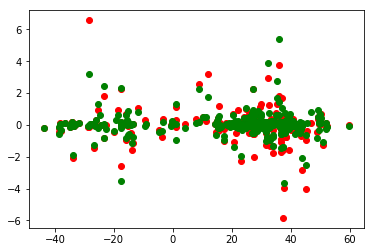

In [374]:
y=df['slope_LC']
y1=df['slope_ME']
x=df['lat']
plt.plot(x,y,'or')
plt.plot(x,y1,'og')

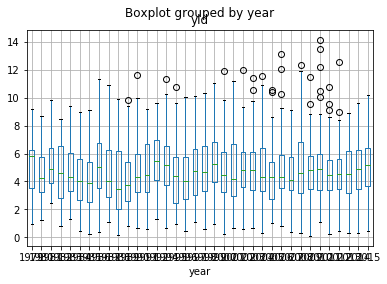

In [68]:
yld.head()

,occ,loc,year,sid,gen,yld
0,1,12302,1979,9,VULTURE,2.467
1,1,12302,1979,113,TOWHEE,3.406
2,1,12302,1979,9,NACOZARI F 76,3.361
3,1,12302,1979,10,VEERY #10,3.117
4,1,12302,1979,16,PEWEE,3.4


In [340]:
#Check which sites are out of range?
n='ESWYT'
base_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\1.0_Cross_Over\\"
yld=pd.read_csv(base_dir+'1_Data/'+n+'_yld.csv')
#yld=yld.groupby(['year'])
yld=yld[['loc','year','yld']].replace(r'^\s+$', np.nan, regex=True)
yld=yld.dropna()
yld.loc[:,'yld']=yld['yld'].astype('float')
yld=yld.groupby(['loc','year']).mean()
loc=yld.groupby('loc').count().reset_index()
loc=loc[loc.yld>=1]['loc'].tolist()

In [341]:
Site1=pd.read_csv(data_out+'modeled_site_mean_yld.csv')
Site1=Site1[Site1['nursery']==n]
Site1=Site1[Site1['loc'].isin(loc).tolist()].dropna()
Site1=Site1[(Site1.meanyld<=Site1.meanyld.mean()+np.std(Site1.meanyld))&(Site1.meanyld>=Site1.meanyld.mean()-np.std(Site1.meanyld))].dropna()

In [ ]:
a=0.1
per=['sea','veg','rep','gfi']
env_cli=['tmax','tmin','pre','rad','vpd','hud']
Wea='ARC5'
wea_dir=data_out

data_out="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\1.0_Cross_Over\\2_Results\\NP_data\\"
fit_ori=pd.read_csv(data_out+"NoEj_"+str(a)+'_fit_quad_tmatmiprravphu_vegrefgif_'+Wea+'_withGi.csv')
fit_ori=fit_ori[fit_ori['G!']!='1_LOCAL CHECK']

Effect=['FixEj','VarEj']
Sites=['All','Gt2','Gt5','Gt10']
Sites_Value=[1,2,5,10]
Outliner=['SD','2SD','Q99','Q95']
out=pd.DataFrame(columns=['Effect','Site','Outline','nursery','year','cultivar','nline','nsite','cross-over'])

Site_ori=pd.read_csv(data_out+'loc_season_number.csv')
Site1_ori=pd.read_csv(data_out+'modeled_site_mean_yld.csv')

for n in nursery:
    fit_n=fit_ori[fit_ori['nursery']==n].iloc[:,3:]
    line_group=int(len(fit_n)/50)
    Site=Site_ori[Site_ori.nursery==n]
    Site1=Site1_ori[Site1_ori.nursery==n]
    for yr in range(1980,2019):
        name=[]
        for pe in per[1:]:
            for x in env_cli:
                name.append(x+'_'+pe+'SQ')
                name.append(x+'_'+pe)
        cli=pd.read_csv(wea_dir+'Climate/'+Wea+'_cli4all_clean_'+n+'_'+per[1]+'_'+str(yr)+'.csv')
        #cli=pd.read_csv(wea_dir+'Climate/cli4all_clean_'+n+'_'+per[1]+'_'+str(yr)+'.csv')
        cli=cli[['loc']+env_cli]
        cli.columns=['loc']+[x+'_'+per[1] for x in cli.columns[1:]]
        for s in per[2:]:
            temp=pd.read_csv(wea_dir+'Climate/'+Wea+'_cli4all_clean_'+n+'_'+s+'_'+str(yr)+'.csv')
            #temp=pd.read_csv(wea_dir+'Climate/cli4all_clean_'+n+'_'+s+'_'+str(yr)+'.csv')
            temp=temp[env_cli]
            temp.columns=[x+'_'+s for x in temp.columns]
            cli=pd.concat([cli,temp],axis=1)
        for col in cli.columns[1:]: cli[col+'SQ']=cli[col]**2
        cli=cli[['loc']+name]
        for g in range(line_group):
            fit_g=fit_n.iloc[(g*50):((g+1)*50),:]
            for E in range(2):#Ej
                for S in range(4): #Site
                    for O in range(4): #Outliner
                        loc=Site[Site['seasonn']>=Sites_Value[S]]
                        loc1=Site1[Site1['loc'].isin(loc['loc'].tolist())]
                        if O==0:
                            loc1=loc1[(loc1.meanyld<(loc1.meanyld.mean()+np.std(loc1.meanyld)))&(loc1.meanyld>(loc1.meanyld.mean()-np.std(loc1.meanyld)))].dropna()
                        if O==1:
                            loc1=loc1[(loc1.meanyld<(loc1.meanyld.mean()+2*np.std(loc1.meanyld)))&(loc1.meanyld>(loc1.meanyld.mean()-2*np.std(loc1.meanyld)))].dropna()
                        if O==2:
                            loc1=loc1[(loc1.meanyld>loc1.meanyld.quantile(q=0.01))&(loc1.meanyld<loc1.meanyld.quantile(q=0.99))].dropna()
                        if O==3:
                            loc1=loc1[(loc1.meanyld>loc1.meanyld.quantile(q=0.05))&(loc1.meanyld<loc1.meanyld.quantile(q=0.95))].dropna()                    
                        #cli=cli.merge(Ej_n,on='loc',how='left')
                        #cli=cli[cli['loc'].isin(loc)].dropna()
                        cli=cli[cli['loc'].isin(loc1['loc'].tolist())].dropna()
                        loc_again=loc1[loc1['loc'].isin(cli['loc'].tolist())]

                        #yld.pivot_table(index='loc',columns='year',aggfunc='count').reset_index()
                        A=np.asarray(fit_g.iloc[:,1:37]).dot(np.asarray(cli.loc[:,fit_g.columns[1:37]]).T)
                        A=pd.DataFrame(A)
                        for j in range(A.shape[1]): A.iloc[:,j]=A.iloc[:,j]+fit_g.iloc[:,0].values+fit_g.loc[:,'Gi'].values#+u

                        fit=[]
                        for row in range(A.shape[0]):
                            temp=pd.DataFrame()
                            temp['yld']=A.iloc[row,:]
                            if E==0: #Fix E
                                temp['mean']=loc_again.meanyld.tolist()#A.mean(axis=0) #
                            else:
                                temp['mean']=A.mean(axis=0)
                            temp=temp.dropna()
                            X_opt = np.asarray(temp['mean'])
                            X_opt=sm.add_constant(X_opt)
                            y=np.asarray(temp['yld'])
                            OLS = sm.OLS(endog = y, exog = X_opt).fit()
                            fit=fit+[OLS.params.tolist()]
                            #sns.regplot(temp['mean'],temp['yld'],ci=0)
                        cross=pd.DataFrame()
                        gen=np.asarray([[i,j] for i in range(len(fit)-1) for j in range(i+1,len(fit))])
                        cross['a1']=[fit[i][1] for i in gen[:,0]] 
                        cross['b1']=[fit[i][0] for i in gen[:,0]]
                        cross['a2']=[fit[i][1] for i in gen[:,1]] 
                        cross['b2']=[fit[i][0] for i in gen[:,1]]
                        cross['s']=(cross['b2']-cross['b1'])/(cross['a1']-cross['a2'])
                        #cross['cross']=[1 if (x>A.mean(axis=0).min())&(x<A.mean(axis=0).max()) else 0 for x in cross['s']]
                        if E==0:
                            cross['cross']=[1 if (x>Site_again.meanyld.min())&(x<Site_again.meanyld.max()) else 0 for x in cross['s']]
                        else:
                            cross['cross']=[1 if (x>A.mean(axis=0).min())&(x<A.mean(axis=0).max()) else 0 for x in cross['s']]
                        cross_n=cross['cross'].sum()
                        out.loc[len(out)]=[Effect[E],Sites[S],Outliner[O],n,yr,g+1,fit_g.shape[0],cli.shape[0],cross_n]

#out=pd.DataFrame(columns=['Eeffect','Site','Outline','nursery','year','cultivar','nline','nsite','cross-over'])
                        #Plot and estimate change
Result=pd.DataFrame(columns=['Ej','Site','Outliner','nursery','change'])
for E in out.Eeffect.unique():
    for S in out.Site.unique():
        for O in out.Outline.unique():
            for n in nursery():
                df=out[out.Eeffect==E & out.Site==S & out.Outline==O & out.nursery==n][['year','nline','cross-over']].apply(pd.to_numeric)
                df['cross']=100*df['cross-over']/(df['nline']*(df['nline']-1)/2)
                df=df.groupby('year').mean().reset_index()
                X_opt=np.asarray(df['year'])
                X_opt=sm.add_constant(X_opt)
                y=np.asarray(df['cross'].astype('float'))
                OLS = sm.OLS(endog = y, exog = X_opt).fit()
                bs=OLS.params[0]+OLS.params[1]*df['year'].min()
                Result.loc[len(Result)]=[Effect[E],Sites[S],Outliner[O],n,OLS.params[1]*39*100/bs]

In [347]:
OLS.params[1]*39*100/bs

-1.1464389245915663

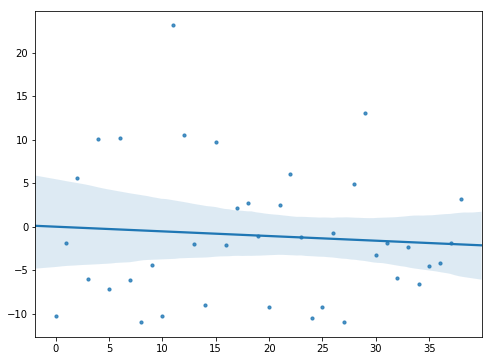

In [311]:
#sns.regplot(out['year'],out['cross-over'])
fig, ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
df=out[['year','nline','cross-over']].apply(pd.to_numeric)
df['cross']=100*df['cross-over']/(df['nline']*(df['nline']-1)/2)
df=df.groupby('year').mean().reset_index()
X_opt=np.asarray(df['year'].astype('float'))
X_opt=sm.add_constant(X_opt)
y=np.asarray(df['cross'].astype('float'))
OLS = sm.OLS(endog = y, exog = X_opt).fit()
bs=OLS.params[0]+OLS.params[1]*df['year'].min()
cross=100*(df['cross']-bs)/bs
#ax.scatter(out['year'].astype('float'),cross,alpha=0.3,s=28)
X=np.asarray(list(range(39)))
sns.regplot(X,np.asarray(cross),ax=ax,scatter=True,scatter_kws={"s": 10})

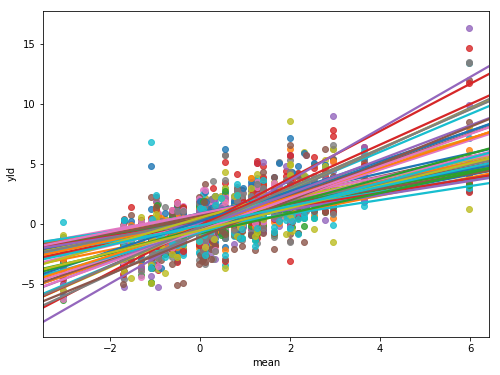

In [124]:
fig, ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))

fit=[]
for row in range(A.shape[0]):
    temp=pd.DataFrame()
    temp['yld']=A.iloc[row,:]
    temp['mean']=A.mean(axis=0)
    temp=temp.dropna()
    X_opt = np.asarray(temp['mean'])
    X_opt=sm.add_constant(X_opt)
    y=np.asarray(temp['yld'])
    OLS = sm.OLS(endog = y, exog = X_opt).fit()
    fit=fit+[OLS.params.tolist()]
    sns.regplot(temp['mean'],temp['yld'],ci=0)
cross=pd.DataFrame()
gen=np.asarray([[i,j] for i in range(len(fit)-1) for j in range(i+1,len(fit))])
cross['a1']=[fit[i][1] for i in gen[:,0]] 
cross['b1']=[fit[i][0] for i in gen[:,0]]
cross['a2']=[fit[i][1] for i in gen[:,1]] 
cross['b2']=[fit[i][0] for i in gen[:,1]]
cross['s']=(cross['b2']-cross['b1'])/(cross['a1']-cross['a2'])
#cross['cross']=[1 if (x>=A0.mean(axis=0).min())&(x<=A0.mean(axis=0).max()) else 0 for x in cross['s']]
cross['cross']=[1 if (x>A.mean(axis=0).min())&(x<A.mean(axis=0).max()) else 0 for x in cross['s']]
cross_n=cross['cross'].sum()

In [180]:
def hex_to_RGB(hex):
  ''' "#FFFFFF" -> [255,255,255] '''
  # Pass 16 to the integer function for change of base
  return [int(hex[i:i+2], 16) for i in range(1,6,2)]
def RGB_to_hex(RGB):
  ''' [255,255,255] -> "#FFFFFF" '''
  # Components need to be integers for hex to make sense
  RGB = [int(x) for x in RGB]
  return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])
def color_dict(gradient):
  ''' Takes in a list of RGB sub-lists and returns dictionary of
    colors in RGB and hex form for use in a graphing function
    defined later on '''
  return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
      "r":[RGB[0] for RGB in gradient],
      "g":[RGB[1] for RGB in gradient],
      "b":[RGB[2] for RGB in gradient]}
def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
  ''' returns a gradient list of (n) colors between
    two hex colors. start_hex and finish_hex
    should be the full six-digit color string,
    inlcuding the number sign ("#FFFFFF") '''
  # Starting and ending colors in RGB form
  s = hex_to_RGB(start_hex)
  f = hex_to_RGB(finish_hex)
  # Initilize a list of the output colors with the starting color
  RGB_list = [s]
  # Calcuate a color at each evenly spaced value of t from 1 to n
  for t in range(1, n):
    # Interpolate RGB vector for color at the current value of t
    curr_vector = [
      int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
      for j in range(3)
    ]
    # Add it to our list of output colors
    RGB_list.append(curr_vector)
  return color_dict(RGB_list)
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = [lower_quartile - IQR, upper_quartile + IQR]
    return quartileSet

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,0,'Cultivar change (line age)')

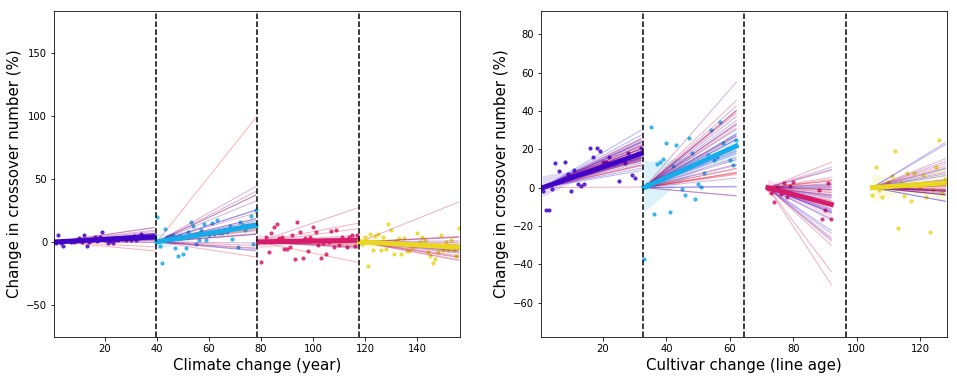

In [190]:
#Plotting
#Color gradients
fittype=['absolute','relative']
colors=['#4203c9', '#16acea', '#d71b6b', '#e8d71e']
colors_start=['#d3ffbe','#bee8ff','#ffbebe','#ffbeff']
colors_end=['#269b00','#004c73','#9b0000','#4c0073']
markers=['.','+','x','*']
x_cross=[10,38,65,92]
rubt1or0 = False

#out=pd.read_csv(data_out+'NoEj_'+str(a)+'_prediction_gxe_crossover_clean_'+Wea+'_All.csv')
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(16,6))
#df0=pd.read_csv(data_out+"NoEj_0.1_prediction_gxe_crossover_clean_METE.csv")
out=pd.read_csv(data_out+"NoEj_0.1_prediction_gxe_crossover_clean_ARC5_SeaGt5.csv")
change=[]
for n in range(4):
    df0=out[out['nursery']==nursery[n]]
    df0['cross']=100*df0['cross-over']/(df0['nline']*(df0['nline']-1)/2)
##############################Climate change#########################################################
    x=np.asarray(list(range(1,40)))+n*39
    #x=np.asarray(list(range(1,34)))+n*33
    #X=np.asarray(x).reshape(-1,1)
    #x=np.asarray(range(1985,2018))
    #"#ffff00","#0000ff" #grey "#F3F0F0","#000000" #Red blue "#FF0000","#0000FF"
    color_ramp=linear_gradient("#FF0000","#0000FF",len(out['cultivar'].unique()))['hex']
    w=0
    for l in df0['cultivar'].unique():
        df=df0[df0['cultivar']==l][['year','cross']]
        X_opt=np.asarray(x)
        X_opt=sm.add_constant(X_opt)
        y=np.asarray(df['cross'])
        OLS = sm.OLS(endog = y.astype(np.float64), exog = X_opt.astype(np.float64)).fit()
        bs=OLS.params[0]+OLS.params[1]*x.min()
        cross=100*(df['cross']-bs)/bs
        sns.regplot(x.astype('float'),cross,scatter=True,ci=0,scatter_kws={'s':0},
                    line_kws={'lw':1,'alpha': 0.3,'color':color_ramp[l-1]},ax=ax[0],truncate=True,robust=rubt1or0)
    df=df0[['year','cross']].apply(pd.to_numeric)
    df=df.groupby('year')['cross'].mean().reset_index()
    X_opt=np.asarray(x)
    X_opt=sm.add_constant(X_opt)
    y=np.asarray(df['cross'])
    OLS = sm.OLS(endog = y.astype(np.float64), exog = X_opt.astype(np.float64)).fit()
    bs=OLS.params[0]+OLS.params[1]*x.min()
    cross=100*(df['cross']-bs)/bs
    #ax[0].scatter(x,cross,c=colors[n],alpha=0.3,s=28)
    sns.regplot(x.astype('float'),cross,scatter=True,ax=ax[0],scatter_kws={"s": 10},
                line_kws={'lw':5},marker='o',color=colors[n],truncate=True,robust=rubt1or0)
    change=change+[OLS.params[1]*39*100/bs]
    #change_=round(xx.get_lines()[n].get_ydata()[len(xx.get_lines()[n].get_ydata())-1]-xx.get_lines()[n].get_ydata()[n],0)
    #ax[0,1].text(x_gxe[n],-66,str(change_)+'%',fontsize=12)
#################################################Breeding progress###################################################
    if n==0 or n==3:x=np.asarray(df0['cultivar'].unique()+(32-len(df0['cultivar'].unique())))+n*32 #ESWYT
    if n==1: x=np.asarray(df0['cultivar'].unique())+n*32
    if n==2: x=np.asarray([8,9,10,11,12,13,14,15,16,24,25,26,27,28])+n*32

    #X=np.asarray(x).reshape(-1,1)
    #x=np.asarray(out['cultivar'].unique()+(27-len(out['cultivar'].unique())))
    color_ramp=linear_gradient("#FF0000","#0000FF",len(out['year'].unique()))['hex']
    w=0
    for l in df0['year'].unique():
        df=df0[df0['year']==l][['cultivar','cross']]
        X_opt=np.asarray(x)
        X_opt=sm.add_constant(X_opt)
        y=np.asarray(df['cross'])
        OLS = sm.OLS(endog = y.astype(np.float64), exog = X_opt.astype(np.float64)).fit()
        bs=OLS.params[0]+OLS.params[1]*x.min()
        cross=100*(df['cross']-bs)/bs
        sns.regplot(x.astype('float'),cross,scatter=True,ci=0,scatter_kws={'s':0},
                    line_kws={'lw':1,'alpha': 0.3,'color':color_ramp[l-1985]},ax=ax[1],truncate=True,robust=rubt1or0)
#        w=w+1
    df=df0[['cultivar','cross']].apply(pd.to_numeric)
    df=df.groupby('cultivar')['cross'].mean().reset_index()   
    X_opt=np.asarray(x)
    X_opt=sm.add_constant(X_opt)
    y=np.asarray(df['cross'])
    OLS = sm.OLS(endog = y.astype(np.float64), exog = X_opt.astype(np.float64)).fit()
    bs=OLS.params[0]+OLS.params[1]*x.min()
    cross=100*(df['cross']-bs)/bs
    #ax[1].scatter(x,cross,c=colors[n],alpha=0.3,s=28)
    sns.regplot(x.astype('float'),cross,scatter=True,ax=ax[1],scatter_kws={"s": 10},
                line_kws={'lw':5},marker='o',color=colors[n],truncate=True,robust=rubt1or0)
#Text and labels
#for col in range(2):
#ax[0].set_xlim([0.5,132.5])
ax[0].set_xlim([0.5,156.5])
ax[0].axvline(39.5,color='black',ls='--')
ax[0].axvline(78.5,color='black',ls='--')
ax[0].axvline(117.5,color='black',ls='--')
#ax[0].set_xticks([])

ax[1].set_xlim([0.5,128.5])
ax[1].axvline(32.5,color='black',ls='--')
ax[1].axvline(64.5,color='black',ls='--')
ax[1].axvline(96.5,color='black',ls='--')
#ax[1].set_xticks([])

#Xlim labels
#labels=[5,16,27,38,49,60,71,82,93,104,115,126]
#labels_year=[1990,2001,2012,1990,2001,2012,1990,2001,2012,1990,2001,2012]
#ax[0].set_xticks(labels)
#ax[0].set_xticklabels(labels_year,fontsize=12) #,rotation=270, ha='right')

#labels=[5,13,22,32,41,50,59,68,77,86,95,104]
#labels_line=[5,13,22,5,13,22,5,13,22,5,13,22]
#labels_line=[30,20,10,30,20,10,30,20,10,30,20,10]
#ax[1].set_xticks(labels)
#ax[1].set_xticklabels(labels_line,fontsize=12)

#ax[0].set_ylim([-100,220])
#ax[0].text(ax[0].get_xlim()[0]+(ax[0].get_xlim()[1]-ax[0].get_xlim()[0])/40,
#           ax[0].get_ylim()[1]-(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])/15,'a',fontsize=20)
#ax[0,0].text(1,-65,'$\it{Total Change =}$')
#ax[0,0].text(13,-90,'23%',fontsize=12) #GEI ESWYT
#ax[0,0].text(45,-90,'39%$\mathregular{^{*}}$',fontsize=12) #GEI ESWYT
#ax[0,0].text(78,-90,'14%',fontsize=12) #GEI ESWYT
#ax[0,0].text(112,-90,'36%',fontsize=12) #GEI ESWYT

#ax[0].set_ylim([-10,10])
#ax[0].text(ax[0].get_xlim()[0]+(ax[0].get_xlim()[1]-ax[0].get_xlim()[0])/40,
#           ax[0].get_ylim()[1]-(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])/15,'a',fontsize=20)
#ax[0,1].text(13,-66,'3%',fontsize=12) #GEI CROSS
#ax[0,1].text(45,-66,'25%$\mathregular{^{***}}$',fontsize=12) #GEI CROSS
#ax[0,1].text(77,-66,'-18%$\mathregular{^{*}}$',fontsize=12) #GEI CROSS
#ax[0,1].text(113,-66,'7%',fontsize=12) #GEI CROSS

#ax[1,0].set_ylim([-100,220])
#ax[1,0].text(ax[1,0].get_xlim()[0]+(ax[1,0].get_xlim()[1]-ax[1,0].get_xlim()[0])/37,
#           ax[1,0].get_ylim()[1]-(ax[1,0].get_ylim()[1]-ax[1,0].get_ylim()[0])/15,'c',fontsize=20)
#ax[1,0].text(10,-90,'-50%',fontsize=12) #GEI ESWYT
#ax[1,0].text(38,-90,'207%',fontsize=12) #GEI ESWYT
#ax[1,0].text(65,-90,'-98%$\mathregular{^{**}}$',fontsize=12) #GEI ESWYT
#ax[1,0].text(92,-90,'-63%',fontsize=12)

#ax[1].set_ylim([-70,70])
#ax[1].text(ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])/37,
#          ax[1].get_ylim()[1]-(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])/15,'b',fontsize=20)
#ax[1].text(10,-66,'9%',fontsize=12) #CROSS ESWYT
#ax[1].text(37,-66,'22%$\mathregular{^{*}}$',fontsize=12) #CROSS ESWYT
#ax[1].text(65,-66,'14%',fontsize=12) #CROSS ESWYT
#ax[1].text(92,-66,'0%',fontsize=12) #CROSS ESWYT
ax[0].set_ylabel("Change in crossover number (%)",fontsize=15)
ax[1].set_ylabel("Change in crossover number (%)",fontsize=15)
ax[0].set_xlabel("Climate change (year)",fontsize=15)
ax[1].set_xlabel("Cultivar change (line age)",fontsize=15)
#for n in range(2): 
#    ax[0,n].text(9,ax[0,n].get_ylim()[1]+(ax[0,n].get_ylim()[1]-ax[0,n].get_ylim()[0])/30,nursery[0],fontsize=15)
#    ax[0,n].text(9+33,ax[0,n].get_ylim()[1]+(ax[0,n].get_ylim()[1]-ax[0,n].get_ylim()[0])/30,nursery[1],fontsize=15)
#    ax[0,n].text(9+32*2,ax[0,n].get_ylim()[1]+(ax[0,n].get_ylim()[1]-ax[0,n].get_ylim()[0])/30,nursery[2],fontsize=15)
#    ax[0,n].text(9+32*3,ax[0,n].get_ylim()[1]+(ax[0,n].get_ylim()[1]-ax[0,n].get_ylim()[0])/30,nursery[3],fontsize=15)
#    ax[n,0].set_ylabel("Change in Sum of Square of GEI (%)",fontsize=15)
#    ax[n,1].set_ylabel("Change in crossover number (%)",fontsize=15)
#    ax[0,n].set_xlabel("Climate change (year)",fontsize=15)
#    ax[1,n].set_xlabel("Cultivar change (line age)",fontsize=15)


In [191]:
change

[4.058328796169964, 13.35792269135328, 1.2830468528661831, -4.410894218674134]